# KCUSUM - Kernel Change Point Detection

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import show
import os
import sys
import pandas as pd
import scipy.io
from random import uniform
import ray
from fitter import Fitter, get_common_distributions
import warnings

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

### Data Loader

#### Nested Atomic Coords

In [2]:
mat = scipy.io.loadmat('collision_0-256.mat')
data = mat['trace']
xyz_coords = data

print("The input dimensions are: (Step, Number of Atoms, Number of Coordinate Dimensions)")
xyz_coords.shape

The input dimensions are: (Step, Number of Atoms, Number of Coordinate Dimensions)


(255, 9033, 3)

In [3]:
buffer_set = xyz_coords.copy() #Deep copy

#### Split-File Axes

In [9]:
data_x = np.loadtxt("pro_1h9t_x.csv",
                 delimiter=",", dtype=float)

data_y = np.loadtxt("pro_1h9t_y.csv",
                 delimiter=",", dtype=float)

data_z = np.loadtxt("pro_1h9t_z.csv",
                 delimiter=",", dtype=float)
data_x

array([-58.937519, -59.014721, -59.285526, ..., -70.826927, -71.063408,
       -71.185127])

#### .XYZ Coords - Processed

In [ ]:
data_xyz = pd.read_csv('1H9T_mean_nT.csv', header=None)
data_xyz

In [ ]:
buffer_set = data_xyz.copy()

### Gaussian Kernel

In [3]:
def gk(x,y):
  return np.exp(-((x-y)**2/2.0))


def mmd(x_n_1, x_n, y_n_1, y_n):
    xx = gk(x_n_1, x_n)
    yy = gk(y_n_1, y_n)
    xy = gk(x_n_1, y_n)
    yx = gk(x_n, y_n_1)
    return xx + yy - xy - yx  

### KCUSUM

In [4]:
T_kcusum = 0
global T_kcusum

In [5]:
@ray.remote

def KCUSUM(x_1, x_2, yz_1, yz_2, h,delta):
    global T_kcusum
    T_kcusum = 0
    Z_n = 0
    h >= 0
    delta >= 0
    c_1 = x_1
    c_2 = x_2
    d_1 = yz_1
    d_2 = yz_2
    stat_values = []
    index_1 = []
    
    for i in np.arange(2,len(c_1),2):

            av_n = mmd(c_1[i],c_2[i-1],d_1[i],d_2[i-1])
            c_n = av_n - delta
            v_n = c_n
            Z_n += v_n
            stat_values = np.append(stat_values,Z_n)
            
            print(i)
            print(f'{av_n=}')
            print(f'{c_n=}')
            print(f'{v_n=}')
            print(f'{Z_n=}')
            print('\n')

            if Z_n < 0:
                Z_n = 0
                print(f'{Z_n=}')

            if Z_n > h:
                T_kcusum = i
                break

            continue    
    
    print("A change point as been detected")
    index_1 = np.arange(2,2*len(stat_values)+1,2)
    plt.plot(index_1,stat_values)
    plt.axhline(h , color = 'r', linestyle = '-')
    plt.ylabel('Threshold Value (Z_n)')
    plt.xlabel('Time')
    plt.xticks(np.arange(2,2*len(stat_values)+1,2))
    plt.xticks(fontsize=8)
    plt.scatter(index_1[-1],h)
    plt.text(index_1[-1],h,'CP Detected',horizontalalignment='right')
    plt.show()
    return T_kcusum

### Abrupt Change Point Injection + Reference Sampling

In [7]:
for i in range(0,51):
    test_set = buffer_set
    D_filt = np.random.normal(1,.5, size = (9033,3))
    test_set[i+49] += D_filt
    
    if i == 50:
        print(test_set.shape)

(255, 9033, 3)


In [12]:
#Reference sampling based on fitted distribution

ref_data_x = np.random.weibull(-62,3141)

ref_data_y = np.random.gamma(25,2,3141)

ref_data_z = np.random.standard_cauchy(3141)

len(ref_data_x)

3141

### SVD

In [8]:
def svd_wrapper(Y, k, method='svds'):
    if method is 'svds':
        Ut, St, Vt = svds(Y, k)
        idx = np.argsort(St)[::-1]        
        St = St[idx] # have issue with sorting zero singular values
        Ut, Vt = svd_flip(Ut[:, idx], Vt[idx])
    elif method is 'random':
        Ut, St, Vt = randomized_svd(Y, k)
    else:
        Ut, St, Vt = np.linalg.svd(Y, full_matrices=False)
        # now truncate it to k
        Ut = Ut[:, :k]
        St = np.diag(St[:k])
        Vt = Vt[:k, :]
        
    return Ut, St, Vt

#### If reduction methods are needed

In [ ]:
(x2,y2,z2) = test_set.shape
test_set.shape
t2 = test_set.reshape((x2, y2*z2),order='C')
#t2 

In [ ]:
(x3,y3,z3) = shapetest.shape
shapetest.shape
t3 = shapetest.reshape((x3, y3*z3),order='C')
#t3

In [ ]:
Utl, Stl, VTtl = svd_wrapper(t2, 2, method='random')

In [ ]:
Utl_2, Stl_2, VTtl_2 = svd_wrapper(t3, 2, method='random')
Utl_2

### Data Processing

#### If nested array, finds mean along axis each frame

#### Using as simple method for quick dev/debug

In [9]:
mean_x = np.mean(test_set[:,:,0],axis=1)
mean_y = np.mean(test_set[:,:,1],axis=1)
mean_z = np.mean(test_set[:,:,2],axis=1)

In [10]:
mean_x2 = np.mean(xyz_coords[:,:,0],axis=1)
mean_y2 = np.mean(xyz_coords[:,:,1],axis=1)
mean_z2 = np.mean(xyz_coords[:,:,2],axis=1)

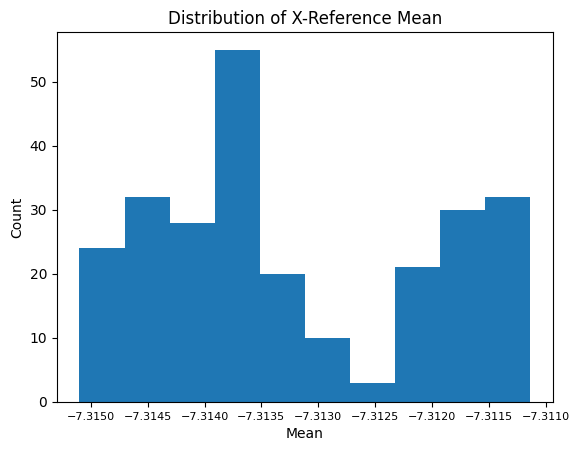

In [11]:
plt.hist(mean_x2)
plt.title("Distribution of X-Reference Mean")
plt.ylabel('Count')
plt.xlabel('Mean')
plt.xticks(fontsize=8)
plt.show()

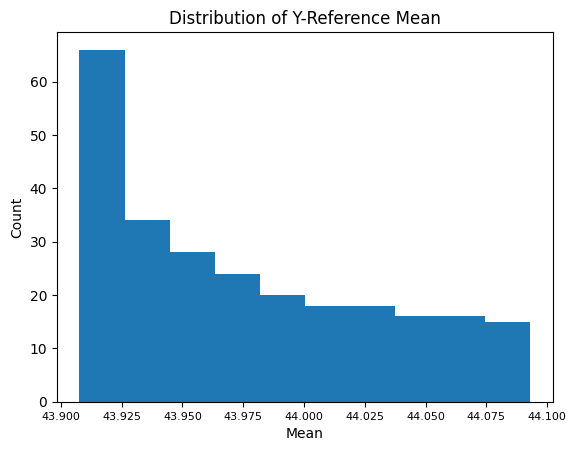

In [12]:
plt.hist(mean_y2)
plt.ylabel('Count')
plt.xlabel('Mean')
plt.title("Distribution of Y-Reference Mean")
plt.xticks(fontsize=8)
plt.show()

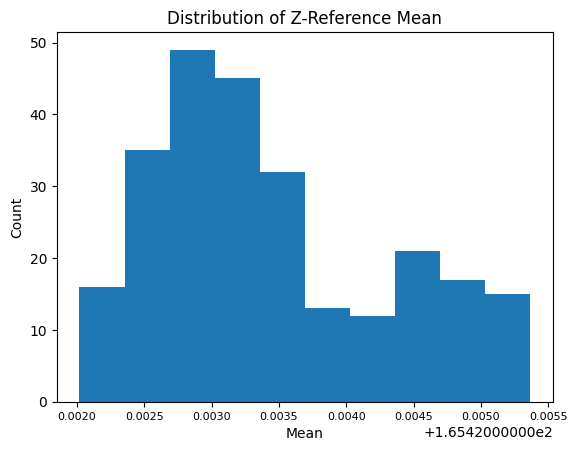

In [13]:
plt.hist(mean_z2)
plt.ylabel('Count')
plt.xlabel('Mean')
plt.title("Distribution of Z-Reference Mean")
plt.xticks(fontsize=8)
plt.show()

### Distribution Fitting

#### Temp method until batch case

In [14]:
SR_x = pd.Series(mean_x2, name="Distribution Fit of mean_x sample")
SR_y = pd.Series(mean_y2, name="Distribution Fit of mean_y sample")
SR_z = pd.Series(mean_z2, name="Distribution Fit of mean_z sample")

distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                         "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

fit_x = Fitter(SR_x, distributions = distributions_set)
fit_y = Fitter(SR_y, distributions = distributions_set)
fit_z = Fitter(SR_z, distributions = distributions_set)

Fitting 26 distributions: 100%|██████████| 26/26 [00:02<00:00,  9.76it/s]


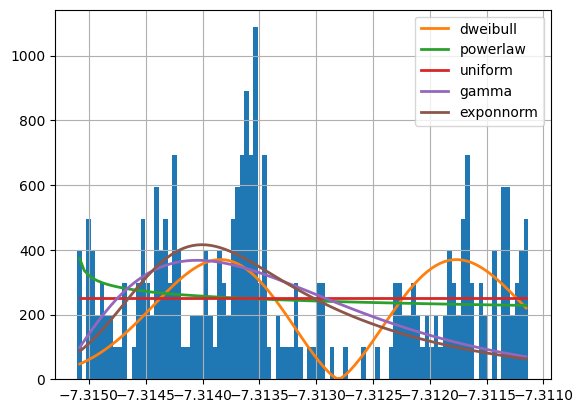

In [15]:
fit_x.fit()
fit_x.summary()
show()

Fitting 26 distributions: 100%|██████████| 26/26 [00:02<00:00, 10.94it/s]


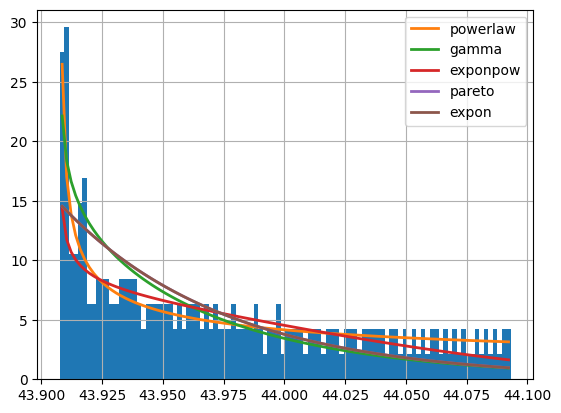

In [16]:
fit_y.fit()
fit_y.summary()
show()

Fitting 26 distributions: 100%|██████████| 26/26 [00:02<00:00, 11.56it/s]


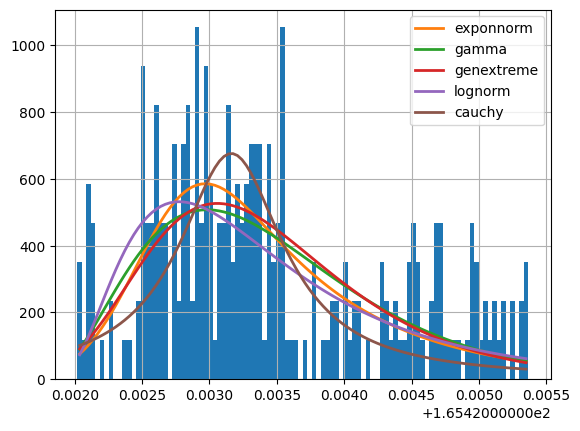

In [17]:
fit_z.fit()
fit_z.summary()
show()

### Ray Threading

In [15]:
ray.shutdown()
ray.init()
x_T,y_T,z_T = ray.get([KCUSUM.remote(data_x,data_x,ref_data_x,ref_data_x,10,1),KCUSUM.remote(data_y,data_y,ref_data_y,ref_data_y,10,1),KCUSUM.remote(data_z,data_z,ref_data_z,ref_data_z,10,1)])
print("A change in X was detected at T = ", x_T)
print("A change in Y was detected at T = ", y_T)
print("A change in Z was detected at T = ", z_T)
plt.show()

(KCUSUM pid=473) Figure(640x480) [repeated 107x across cluster]
(KCUSUM pid=473) A change point as been detected [repeated 2x across cluster]


2023-06-28 23:27:00,691	WARNING services.py:1826 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.95gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-06-28 23:27:00,813	INFO worker.py:1636 -- Started a local Ray instance.


(KCUSUM pid=759) 2
(KCUSUM pid=759) av_n=1.2091632126491385
(KCUSUM pid=759) c_n=0.2091632126491385
(KCUSUM pid=759) v_n=0.2091632126491385
(KCUSUM pid=759) Z_n=0.2091632126491385
(KCUSUM pid=759) 
(KCUSUM pid=759) 
(KCUSUM pid=759) 4
(KCUSUM pid=759) av_n=1.8673875916306866
(KCUSUM pid=759) c_n=0.8673875916306866
(KCUSUM pid=759) v_n=0.8673875916306866
(KCUSUM pid=759) Z_n=1.076550804279825
(KCUSUM pid=759) 
(KCUSUM pid=759) 
(KCUSUM pid=759) 6
(KCUSUM pid=759) av_n=0.15295390296855205
(KCUSUM pid=759) c_n=-0.847046097031448
(KCUSUM pid=759) v_n=-0.847046097031448
(KCUSUM pid=759) Z_n=0.22950470724837713
(KCUSUM pid=759) 
(KCUSUM pid=759) 
(KCUSUM pid=759) 8
(KCUSUM pid=759) av_n=1.9070406528718225
(KCUSUM pid=759) c_n=0.9070406528718225
(KCUSUM pid=759) v_n=0.9070406528718225
(KCUSUM pid=759) Z_n=1.1365453601201996
(KCUSUM pid=759) 
(KCUSUM pid=759) 
(KCUSUM pid=759) 10
(KCUSUM pid=759) av_n=1.845240393257042
(KCUSUM pid=759) c_n=0.845240393257042
(KCUSUM pid=759) v_n=0.8452403932570

### Non-Threaded KCUSUM to isolate issues/parameter space/output

In [19]:
def KCUSUM2(x_1, x_2, yz_1, yz_2, h,delta):
    global T_kcusum
    T_kcusum = 0
    Z_n = 0
    h >= 0
    delta >= 0
    c_1 = x_1
    c_2 = x_2
    d_1 = yz_1
    d_2 = yz_2
    stat_values = []
    index_1 = []
    
    for i in np.arange(2,len(c_1),2):

            av_n = mmd(c_1[i],c_2[i-1],d_1[i],d_2[i-1])
            c_n = av_n - delta
            v_n = c_n
            Z_n += v_n
            stat_values = np.append(stat_values,Z_n)
            
            print(i)
            print(f'{av_n=}')
            print(f'{c_n=}')
            print(f'{v_n=}')
            print(f'{Z_n=}')
            print('\n')

            if Z_n < 0:
                Z_n = 0
                print(f'{Z_n=}')

            if Z_n > h:
                T_kcusum = i
                break

            continue    
    
    print("A change point as been detected")
    index_1 = np.arange(2,2*len(stat_values)+1,2)
    plt.plot(index_1,stat_values)
    plt.axhline(h , color = 'r', linestyle = '-')
    plt.ylabel('Threshold Value (Z_n)')
    plt.xlabel('Time')
    #plt.xticks(np.arange(2,2*len(stat_values)+1,2))
    plt.xticks(fontsize=8)
    plt.scatter(index_1[-1],h)
    plt.text(index_1[-1],h,'CP Detected',horizontalalignment='right')
    plt.show()
    return T_kcusum

2
av_n=1.249639119783802
c_n=-0.15036088021619798
v_n=-0.15036088021619798
Z_n=-0.15036088021619798


Z_n=0
4
av_n=1.0421429918171603
c_n=-0.3578570081828396
v_n=-0.3578570081828396
Z_n=-0.3578570081828396


Z_n=0
6
av_n=0.6237352474729196
c_n=-0.7762647525270803
v_n=-0.7762647525270803
Z_n=-0.7762647525270803


Z_n=0
8
av_n=0.6995874884414991
c_n=-0.7004125115585008
v_n=-0.7004125115585008
Z_n=-0.7004125115585008


Z_n=0
10
av_n=0.6751157870877539
c_n=-0.724884212912246
v_n=-0.724884212912246
Z_n=-0.724884212912246


Z_n=0
12
av_n=-0.021504428488536842
c_n=-1.4215044284885368
v_n=-1.4215044284885368
Z_n=-1.4215044284885368


Z_n=0
14
av_n=-0.004205339453123291
c_n=-1.404205339453123
v_n=-1.404205339453123
Z_n=-1.404205339453123


Z_n=0
16
av_n=0.721062009166503
c_n=-0.6789379908334969
v_n=-0.6789379908334969
Z_n=-0.6789379908334969


Z_n=0
18
av_n=1.6012234203217752
c_n=0.20122342032177531
v_n=0.20122342032177531
Z_n=0.20122342032177531


20
av_n=1.3458771655837036
c_n=-0.054122834416

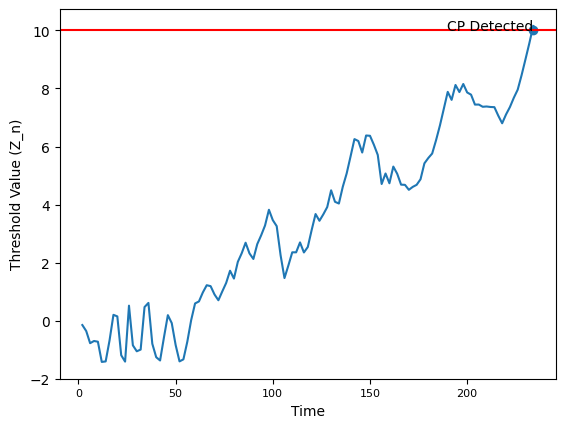

234

In [25]:
KCUSUM2(data_z,data_z,ref_data_z,ref_data_z,10,1.4)